In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, WeibullAFTFitter

In [2]:
ALPHA = 0.11 #Significance level for the prediction intervals

---

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3489/804963022.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Prognosis for women with breast cancer.dat", sep="\s+")


In [4]:
DatOriginal["stain"] = pd.get_dummies(DatOriginal["stain"], drop_first=True, dtype=int)

In [5]:
DatOriginal.head()

,stain,time,status
0,0,23,1
1,0,47,1
2,0,69,1
3,0,70,0
4,0,71,0


---

In [6]:
# Weibull log-hazard function
def WeibullLogHazard(t, alpha, beta):
    return -alpha*np.log(beta) + np.log(alpha) + (alpha-1)*np.log(t)

# Weibull hazard function
def WeibullHazard(t, alpha, beta):
    return np.exp(WeibullLogHazard(t, alpha, beta))

# Weibull log-survivor function
def WeibullLogSurvivor(t, alpha, beta):
    return -1/beta**alpha * t**alpha

# Weibull survivor function
def WeibullSurvivor(t, alpha, beta):
    return np.exp(WeibullLogSurvivor(t, alpha, beta))

# Time quantile
def TimeQuantile(p, alpha, beta):
    return beta * (-np.log(1-p))**(1/alpha)

---

Using Bayesian Statistics

In [7]:
y = DatOriginal["time"].values
cens = (DatOriginal["status"]==0).values

with pm.Model() as WeibullProportionalHazards:
    # Partial regression
    Zeta = pm.Normal("Zeta", mu=0, sigma=10, shape=2)
    #Eta = pm.Deterministic('RiskScore', Zeta[DatOriginal['stain']])

    # Weibull parameters
    Alpha = pm.HalfNormal("Alpha", sigma=10)
    Beta = pm.Deterministic("Beta", np.exp(Zeta))
    
    # Hazard ratio
    Psi = pm.Deterministic("HazardRatio", np.exp(-Alpha* (Zeta[1]-Zeta[0])))

    # Time quantile
    MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Alpha, Beta))

    # Log-likelihood
    Logdensity = pm.Weibull("TimesObserved", Alpha, Beta[DatOriginal[~cens]["stain"]], observed=y[~cens])
    Logsurvivor = pm.Potential("TimesCensored", WeibullLogSurvivor(y[cens], Alpha, Beta[DatOriginal[cens]["stain"]]))

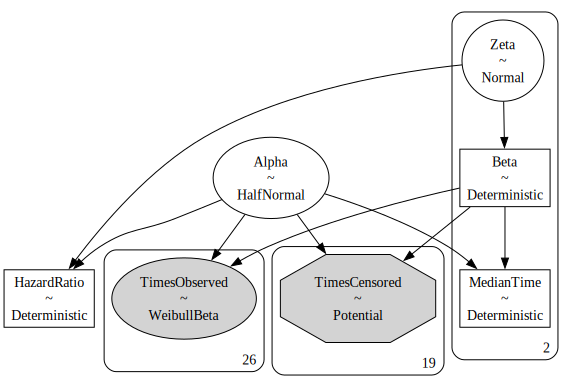

In [8]:
pm.model_to_graphviz(WeibullProportionalHazards)

In [9]:
with WeibullProportionalHazards:
    TraceWeibull = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Zeta, Alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [10]:
az.summary(TraceWeibull, var_names=["Zeta", "Alpha", "HazardRatio"], kind="stats", stat_focus="median", hdi_prob=1-ALPHA)

,median,mad,eti_5.5%,eti_94.5%
Zeta[0],5.948,0.367,5.223,7.086
Zeta[1],4.886,0.167,4.502,5.329
Alpha,0.895,0.100,0.672,1.150
HazardRatio,2.610,0.862,1.226,6.225


(0.0, 10.0)

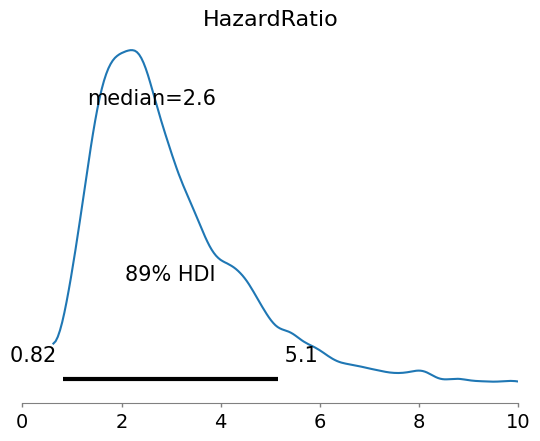

In [11]:
az.plot_posterior(TraceWeibull, var_names=["HazardRatio"], point_estimate="median", hdi_prob=1-ALPHA)
plt.xlim(0,10)

---

Using ``lifelines``

In this case our $\alpha$ is $\exp(\rho)$, and our $\beta$ is $\lambda(x)=\mu+\zeta^Tx$.

Thus, the hazard ratio is given by $\psi=e^{-\alpha\zeta}$

In [12]:
aft = WeibullAFTFitter(alpha=ALPHA)
aft.fit(DatOriginal, 'time', event_col='status')

<lifelines.WeibullAFTFitter: fitted with 45 total observations, 19 right-censored observations>

In [13]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 45 total observations, 19 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 45
number of events observed = 26
           log-likelihood = -156.75
         time fit was run = 2024-12-11 15:39:37 UTC

---
                   coef exp(coef)  se(coef)  coef lower 89%  coef upper 89% exp(coef) lower 89% exp(coef) upper 89%
param   covariate                                                                                                  
lambda_ stain     -1.00      0.37      0.54           -1.87           -0.13                0.15                0.88
        Intercept  5.85    348.76      0.50            5.06            6.65              157.13              774.10
rho_    Intercept -0.06      0.94      0.17           -0.33            0.20                0.72                1.22

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ stain        0.00 -1.83   0.07      3.90
        Intercept    0.00 11.73 <0.005    103.22
rho_    Intercept    0.00 -0.39   0.70      0.52
---
Concordance = 0.60
AIC = 319.49
log-likelihood ratio test = 4.14 on 1 df
-log2(p) of ll-ratio test = 4.58

In [14]:
#alpha
Alpha_aft = aft.summary["exp(coef)"]["rho_"]["Intercept"]

round(Alpha_aft, 4)

0.9374

In [15]:
#hazard ratio
Psi_aft = np.exp(-Alpha_aft * aft.summary["coef"]["lambda_"]["stain"]) 
round(Psi_aft, 4)

2.5454

---

Plot the survivor functions and compare them with the KM estimator

In [16]:
DatOriginalNegative = DatOriginal[DatOriginal['stain']==0]
DatOriginalPositive = DatOriginal[DatOriginal['stain']==1]

In [17]:
t_vect = np.linspace(0, 250)

In [18]:
for t in t_vect:
    if t==t_vect[0]:
        Survivor_0 = az.summary(
            WeibullSurvivor(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,0]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]

        Survivor_1 = az.summary(
            WeibullSurvivor(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,1]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Survivor_0 = pd.concat([
            Survivor_0,
            az.summary(
                WeibullSurvivor(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

        Survivor_1 = pd.concat([
            Survivor_1,
            az.summary(
                WeibullSurvivor(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])
        
Survivor_0['time'] = t_vect
Survivor_1['time'] = t_vect

/home/dmitri/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/dmitri/.local/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


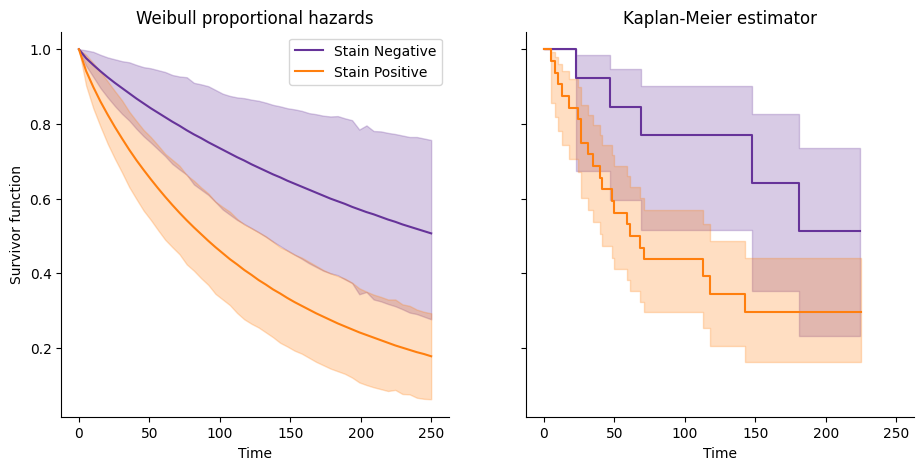

In [19]:
f, ax = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

# Plot our Weibull model
ax[0].plot(
    Survivor_0["time"],
    Survivor_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax[0].fill_between(
    Survivor_0["time"],
    Survivor_0["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor_0["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

ax[0].plot(
    Survivor_1["time"],
    Survivor_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

ax[0].fill_between(
    Survivor_1["time"],
    Survivor_1["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor_1["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color=mpl.colormaps['tab10'].colors[1]
)

ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Survivor function")
ax[0].set_title("Weibull proportional hazards")
ax[0].spines[['right', 'top']].set_visible(False)

# Plot the Kaplan-Meier estimators
kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'])
kmf.plot_survival_function(ax=ax[1], color='rebeccapurple')

kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'])
kmf.plot_survival_function(ax=ax[1])

ax[1].get_legend().remove()
ax[1].set_xlabel("Time")
ax[1].set_title("Kaplan-Meier estimator")
ax[1].spines[['right', 'top']].set_visible(False)

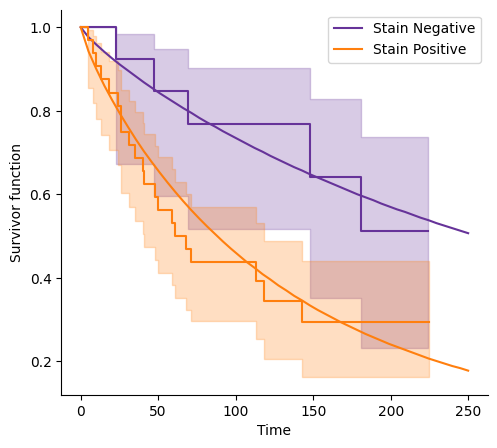

In [20]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

# Plot our Weibull model
ax.plot(
    Survivor_0["time"],
    Survivor_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax.plot(
    Survivor_1["time"],
    Survivor_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

# Plot the Kaplan-Meier estimators
kmf = KaplanMeierFitter(alpha=ALPHA)
kmf.fit(DatOriginalNegative['time'], event_observed=DatOriginalNegative['status'])
kmf.plot_survival_function(ax=ax, color='rebeccapurple', label="")

kmf.fit(DatOriginalPositive['time'], event_observed=DatOriginalPositive['status'])
kmf.plot_survival_function(ax=ax, label="")

ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)


Plot the hazard functions

In [21]:
for t in t_vect:
    if t==t_vect[0]:
        Hazard_0 = az.summary(
            WeibullHazard(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,0]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]

        Hazard_1 = az.summary(
            WeibullHazard(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"][:,:,1]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Hazard_0 = pd.concat([
            Hazard_0,
            az.summary(
                WeibullHazard(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,0]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])

        Hazard_1 = pd.concat([
            Hazard_1,
            az.summary(
                WeibullHazard(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"][:,:,1]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])
        
Hazard_0['time'] = t_vect
Hazard_1['time'] = t_vect

arviz - WARNING - Array contains NaN-value.
arviz - WARNING - Array contains NaN-value.


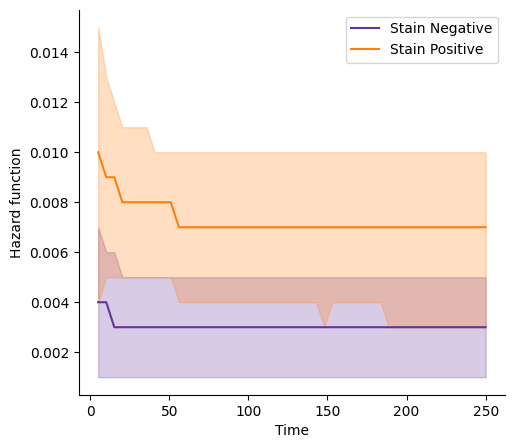

In [22]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    Hazard_0["time"],
    Hazard_0["mean"],
    label="Stain Negative",
    color="rebeccapurple"
)

ax.fill_between(
    Hazard_0["time"],
    Hazard_0["hdi_"+str((ALPHA/2)*100)+"%"],
    Hazard_0["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

ax.plot(
    Hazard_1["time"],
    Hazard_1["mean"],
    label="Stain Positive",
    color=mpl.colormaps['tab10'].colors[1]
)

ax.fill_between(
    Hazard_1["time"],
    Hazard_1["hdi_"+str((ALPHA/2)*100)+"%"],
    Hazard_1["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color=mpl.colormaps['tab10'].colors[1]
)

ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Hazard function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

Plot the Median Survival Times

array([<Axes: title={'center': 'MedianTime\n0'}>,
       <Axes: title={'center': 'MedianTime\n1'}>], dtype=object)

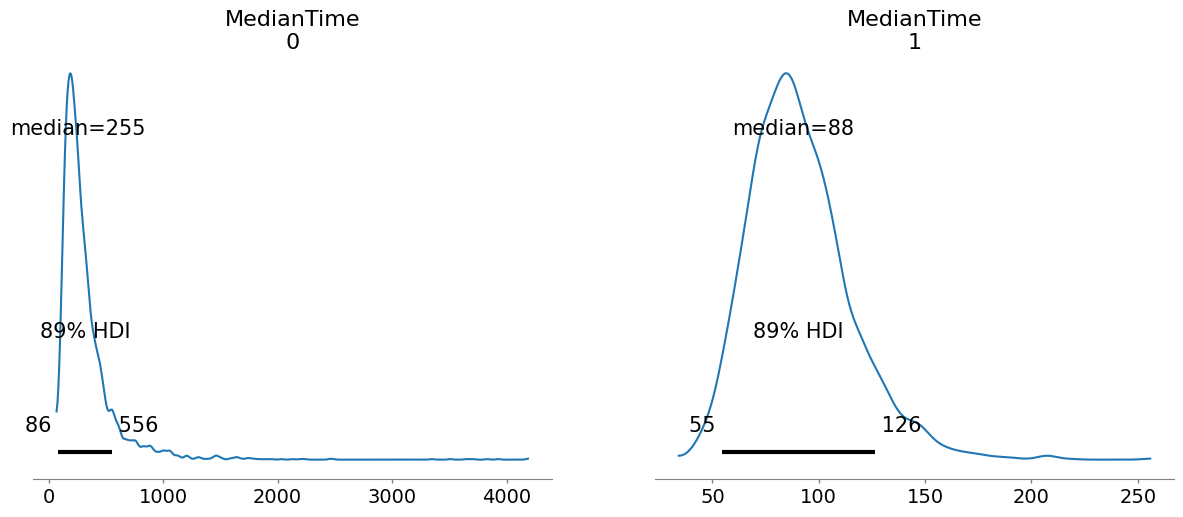

In [ ]:
ax = az.plot_posterior(TraceWeibull, var_names=['MedianTime'], hdi_prob=1-ALPHA, point_estimate="median")

ax[0].set_xlim(0,700)
ax[1].set_xlim(0,250)

Text(0.5, 1.0, 'Median Survival Time')

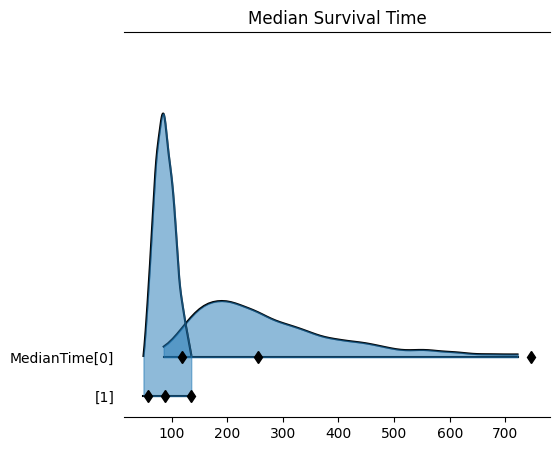

In [25]:
ax = az.plot_forest(
    TraceWeibull,
    kind='ridgeplot',
    var_names=['MedianTime'],
    combined=True,
    ridgeplot_quantiles=[ALPHA/2, 0.5, 1-ALPHA/2],
    ridgeplot_alpha=0.5,
    ridgeplot_overlap=6,
    figsize=(5.5, 5)
)

ax[0].set_title('Median Survival Time')